In [101]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

Populating the interactive namespace from numpy and matplotlib


In [46]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[1:55]].min()

def scale(x):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    scaler.fit(x)# + [0]*52)
    return scaler, scaler.transform(x)

In [114]:
out_dir = '../papi_output/'
path = out_dir + 'o4p-c.csv'

df = pd.read_csv(path) #, header=None)
df = aggregate(df)
df = df.sample(frac=1) # shuffle for better cross-validation

In [115]:
#df = df.drop(df[df['PAPI_TOT_INS'] == 0].index)

#ti = df['PAPI_TOT_INS']
#for col in df.columns[1:53]:
#    df[col] /= ti

for col in df.columns[1:53]:
    df[col] = df[col].apply(lambda q: np.log(q) if q>0 else 0)

x = df.iloc[:,1:53].as_matrix()
scaler, x = scale(x)
y = df.iloc[:,53].as_matrix()

In [116]:
pca = PCA(n_components=2)
pca.fit(x)
x2 = pca.transform(x)

In [117]:
svr = SVR(kernel='linear', C=1, epsilon=.1)
svr.fit(x2, y)

groups = df.index.get_level_values(0)
scores = cross_val_score(svr, x2, y, cv=3, groups=groups) 

print(scores)
scores.mean()

[ 0.01038905 -0.02843412 -0.02076116]


-0.012935410547443257

In [84]:
pca.explained_variance_ratio_.sum()

0.84867811926084247

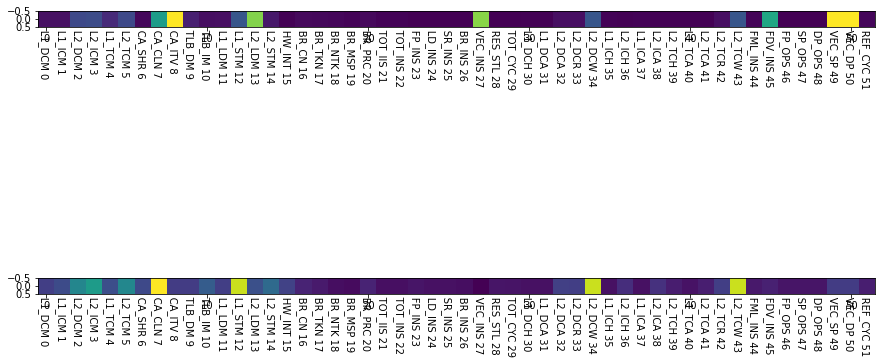

In [85]:
# just to visualize which of 52 PAPI output events are most significant (marked in yellow)

lab = df.columns[1:53]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    for j, txt in enumerate(lab):
        ax.annotate('      '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    ax.imshow(pca.components_[i:i+1])
plt.show()

(array([  5.,  15.,  16.,  25.,  27.,  39.,  42.,  23.,   9.,   3.]),
 array([ 2.9596571 ,  2.99501999,  3.03038288,  3.06574577,  3.10110866,
         3.13647155,  3.17183444,  3.20719733,  3.24256021,  3.2779231 ,
         3.31328599]),
 <a list of 10 Patch objects>)

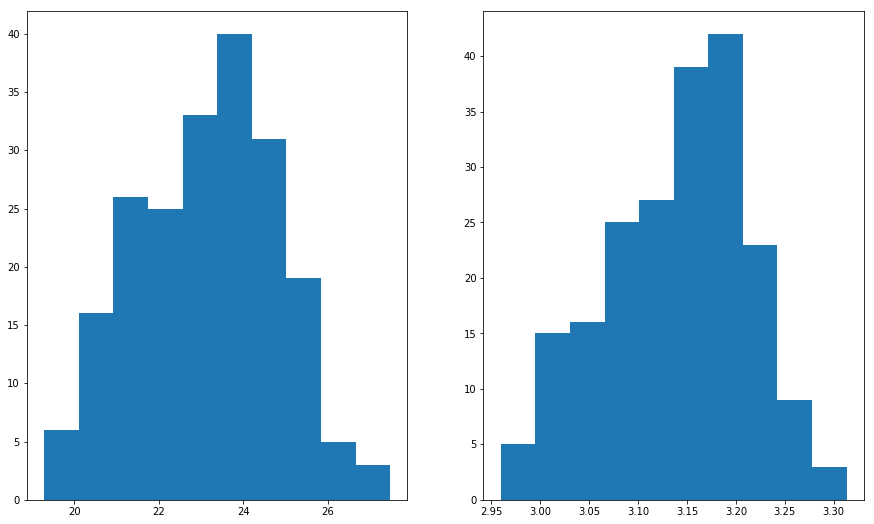

In [86]:
def safe_log(a):
    return [np.log(q) if q>0 else 0 for q in a]
    
a=df['PAPI_TOT_INS']
a = [q for q in a if q>0]
fig, axs = plt.subplots(ncols=2)
axs[0].hist(a)
axs[1].hist([np.log(q) for q in a])

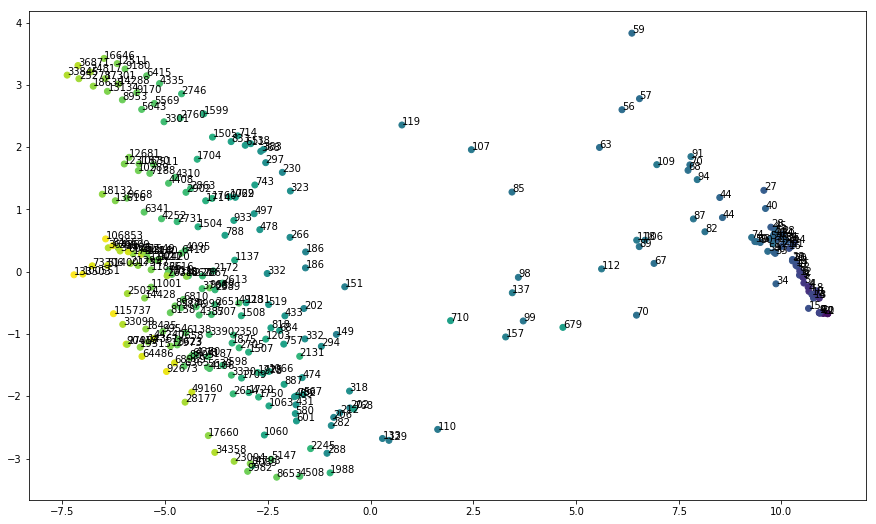

In [87]:
pcaqq = PCA(n_components=2)
pcaqq.fit(x)
x2qq = pca.transform(x)

#lab = df.index.get_level_values(0) #df.iloc[:,22]
lab = [int(q) for q in y]

fig, ax = plt.subplots()
ax.scatter(x2qq[:,0], x2qq[:,1], c=[np.log(q) for q in y])

for i, txt in enumerate(lab):
    ax.annotate(txt, (x2qq[i,0],x2qq[i,1]))

In [88]:
xtest = [657331390,5778,23412169,603,645142543,23412772,10484,0,0,513263004,1610,876758365,182,-35089711,58502483,1555,551511596,547886491,955005,958756,550570076,21595855282,21259346758,3826221919,10344945934,1089807355,550459490,0,13920196862,20376792424,11955131813,12612463203,876758547,876758365,182,20277676628,9349,20277682406,9952,858612095,32890145609,882024867,876768317,182,3257661906,0,3826221919,3826221919,3826221919,0,0,20362666874]
print(len(xtest))
xtest = [np.log(q) if q>0 else 0 for q in xtest]
xtest = scaler.transform([xtest])
xtest = pca.transform(xtest)
print(xtest)
print(svr.predict(xtest))

#for yp, yt in zip(svr.predict(x2), y):
    #print(int(yp), '\t', int(yt))

52
[[-4.34022705 -1.34480108]]
[ 3814.96288224]


In [72]:
svr.score(x2, y)

-0.035379301578628564